In [ ]:
%matplotlib inline

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=pd.errors.DtypeWarning)

In [ ]:
import pandas as pd
import zipfile
import os

# # Define paths
zip_path = 'yg821jf8611_ca_stockton_2020_04_01.csv.zip'
extract_path = '/content/'

# # Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# # List extracted files to confirm the CSV file name
print("Extracted files:", os.listdir(extract_path))

# Set the CSV file path (using the correct file name)
csv_file = 'ca_stockton_2020_04_01.csv'

# Load CSV into a DataFrame
df = pd.read_csv(csv_file)

# Display the first few rows
df.head()

Extracted files: ['.config', 'ca_stockton_2020_04_01.csv', 'yg821jf8611_ca_stockton_2020_04_01.csv.zip', 'sample_data']


,raw_row_number,date,division,subject_age,subject_race,subject_sex,officer_id_hash,type,arrest_made,citation_issued,warning_issued,outcome,search_conducted,search_basis,reason_for_stop,raw_result,raw_search
0,1,2012-01-01,Patrol,57.0,white,male,NaN,vehicular,False,False,True,warning,False,NaN,--Traffic Violation,--Verbal Warning,--No Search Conducted
1,2,2012-01-01,Patrol,22.0,asian/pacific islander,female,6622ed422b,vehicular,False,False,True,warning,False,NaN,--Traffic Violation,--Verbal Warning,--No Search Conducted
2,3,2012-01-02,Patrol,73.0,black,male,NaN,vehicular,False,True,False,citation,False,NaN,--Traffic Violation,--Citation Issued,--No Search Conducted
3,4,2012-01-02,Patrol,31.0,black,female,NaN,vehicular,False,True,False,citation,False,NaN,--Traffic Violation,--Citation Issued,--No Search Conducted
4,5,2012-01-03,Patrol,81.0,white,female,ee82e9851f,vehicular,False,False,True,warning,False,NaN,--Traffic Violation,--Verbal Warning,--No Search Conducted


In [ ]:
import pandas as pd

# Load the dataset
df = pd.read_csv("ca_stockton_2020_04_01.csv")  # Change path if needed

# Drop columns not useful for debiasing tasks
drop_columns = [
    "raw_row_number", "officer_id_hash", "raw_result", "raw_search"
]
df_cleaned = df.drop(columns=[col for col in drop_columns if col in df.columns])

# Drop rows with missing critical demographic or outcome values
required_columns = ["subject_race", "subject_sex", "subject_age", "outcome"]
df_cleaned = df_cleaned.dropna(subset=required_columns)

# Make a copy to avoid SettingWithCopyWarning
df_cleaned = df_cleaned.copy()

# Fill missing values in boolean-like columns
for col in ["arrest_made", "citation_issued", "warning_issued"]:
    df_cleaned[col] = df_cleaned[col].fillna("False")

# Also fill missing reason_for_stop
df_cleaned["reason_for_stop"] = df_cleaned["reason_for_stop"].fillna("Unknown")

# Convert boolean-like columns to actual booleans
for col in ["arrest_made", "citation_issued", "warning_issued"]:
    df_cleaned[col] = df_cleaned[col].astype(str).str.lower().map({"true": True, "false": False})

# One-hot encode categorical variables (except target)
categorical_cols = ["division", "subject_race", "subject_sex", "type", "reason_for_stop"]
df_encoded = pd.get_dummies(df_cleaned, columns=[col for col in categorical_cols if col in df_cleaned.columns], drop_first=True)

# Final output
print(df_encoded.shape)
print(df_encoded.head())


<ipython-input-5-4ee329382603>:21: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_cleaned[col] = df_cleaned[col].fillna("False")


(41212, 21)
         date  subject_age  arrest_made  citation_issued  warning_issued  \
0  2012-01-01         57.0        False            False            True   
1  2012-01-01         22.0        False            False            True   
2  2012-01-02         73.0        False             True           False   
3  2012-01-02         31.0        False             True           False   
4  2012-01-03         81.0        False            False            True   

    outcome  search_conducted search_basis  division_GSET  division_Other  \
0   warning             False          NaN          False           False   
1   warning             False          NaN          False           False   
2  citation             False          NaN          False           False   
3  citation             False          NaN          False           False   
4   warning             False          NaN          False           False   

   ...  division_Traffic  division_UOP  subject_race_black  \
0  ...

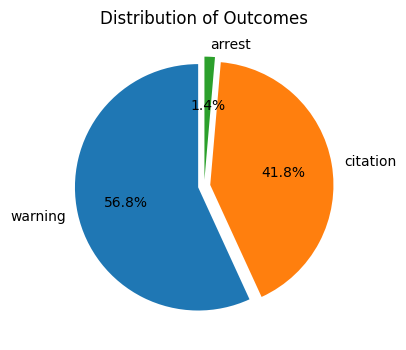

In [ ]:
plt.figure(figsize=(7, 4))
df["outcome"].value_counts().plot(kind="pie", autopct='%1.1f%%', startangle=90, explode=[0.05]*df["outcome"].nunique())
plt.title("Distribution of Outcomes")
plt.ylabel("")
plt.show()



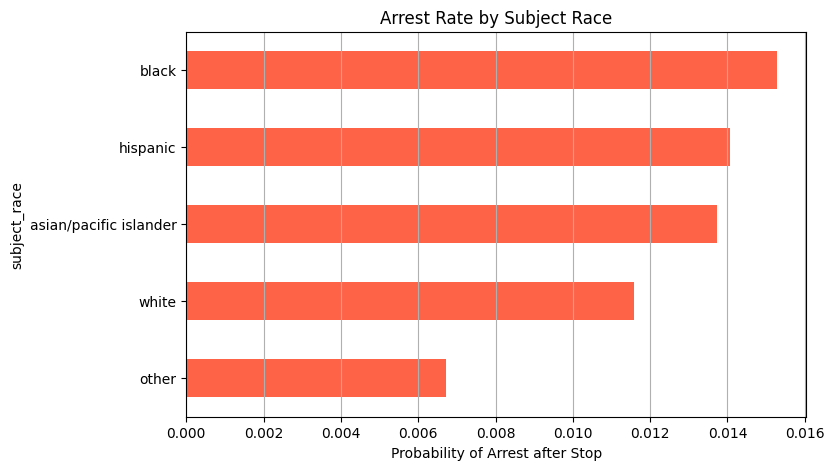

In [ ]:
race_arrest_rate = df.groupby("subject_race")["arrest_made"].mean().sort_values()

plt.figure(figsize=(8, 5))
race_arrest_rate.plot(kind="barh", color='tomato')
plt.title("Arrest Rate by Subject Race")
plt.xlabel("Probability of Arrest after Stop")
plt.grid(axis="x")
plt.show()


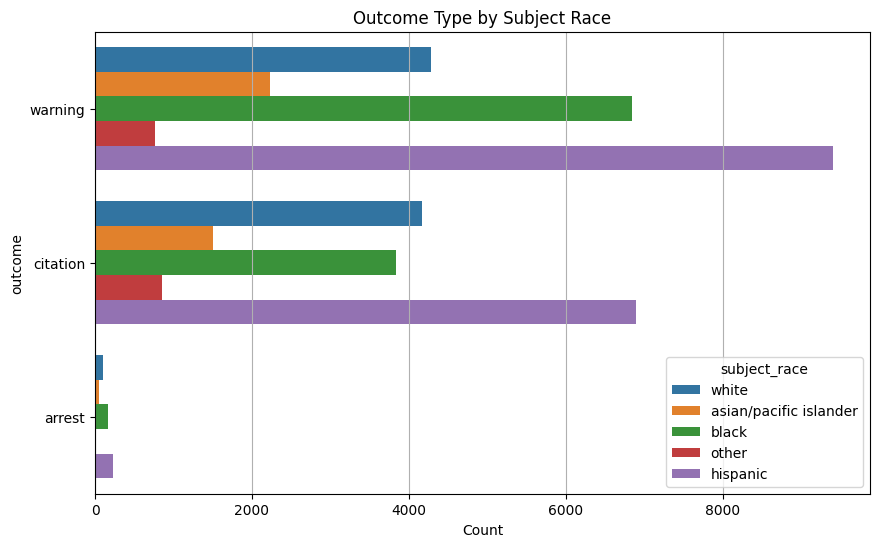

In [ ]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.countplot(y="outcome", hue="subject_race", data=df)
plt.title("Outcome Type by Subject Race")
plt.xlabel("Count")
plt.grid(axis="x")
plt.show()


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Start fresh from the cleaned data
df_fairness = df_cleaned.copy()

# Define the target and protected attribute
target_col = "arrest_made"
protected_col = "subject_race"

# Drop rows where target or protected attribute is missing
df_fairness = df_fairness.dropna(subset=[target_col, protected_col])

# Ensure target is binary 1/0 (already bool but just in case)
df_fairness[target_col] = df_fairness[target_col].astype(bool).astype(int)

# Standardize the protected attribute values (lowercase for safety)
df_fairness[protected_col] = df_fairness[protected_col].astype(str).str.strip().str.lower()

# Define privileged and unprivileged groups
privileged_group = "white"
unprivileged_group = "black"

# Compute arrest rates
total_privileged = df_fairness[df_fairness[protected_col] == privileged_group][target_col].mean()
total_unprivileged = df_fairness[df_fairness[protected_col] == unprivileged_group][target_col].mean()

# Compute disparate impact (avoid divide by zero)
disparate_impact = total_unprivileged / total_privileged if total_privileged != 0 else None

# Show the values
print("Privileged group (white) arrest rate:", total_privileged)
print("Unprivileged group (black) arrest rate:", total_unprivileged)
print("Disparate Impact (unprivileged / privileged):", disparate_impact)


Privileged group (white) arrest rate: 0.011630639097744361
Unprivileged group (black) arrest rate: 0.01524812863875797
Disparate Impact (unprivileged / privileged): 1.3110310199303823


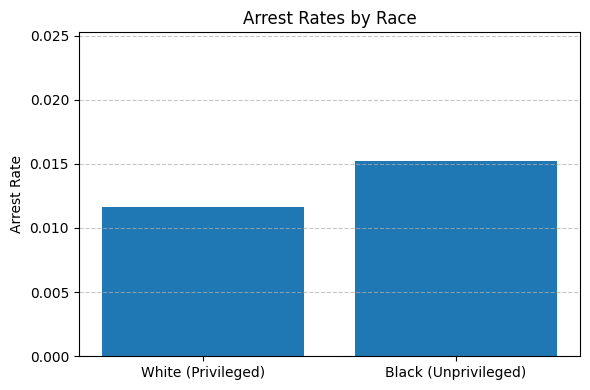

In [ ]:
import matplotlib.pyplot as plt

# Bar plot to show arrest rates by group
groups = ['White (Privileged)', 'Black (Unprivileged)']
rates = [total_privileged, total_unprivileged]

plt.figure(figsize=(6, 4))
plt.bar(groups, rates)
plt.ylabel('Arrest Rate')
plt.title('Arrest Rates by Race')
plt.ylim(0, max(rates) + 0.01)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In the Stockton 2020 dataset, the arrest rate for White individuals — considered the privileged group — was approximately 1.16%, while the arrest rate for Black individuals — considered the unprivileged group — was around 1.52%. When we compute the disparate impact, which measures the relative rate of arrests between unprivileged and privileged groups, we find a value of about 1.31. This means that Black individuals were arrested at a rate roughly 31% higher than White individuals during police stops. A disparate impact close to 1 is generally considered fair, so a value of 1.31 suggests a potential disparity in outcomes based on race in the dataset.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Step 1: Load preprocessed data (you already cleaned it earlier)
df = df_cleaned.copy()

# Step 2: Downsample for memory efficiency
df_sample = df.sample(n=10000, random_state=42) if len(df) > 10000 else df.copy()

# Step 3: Define target and sensitive columns
target_col = "arrest_made"
protected_col = "subject_race"

# Step 4: Create a binary sensitive attribute manually (black vs others)
df_sample["subject_race_black"] = (df_sample[protected_col].str.lower() == "black").astype(int)
sensitive_col = "subject_race_black"

# Step 5: Select numeric features only
X = df_sample.drop(columns=["arrest_made", "outcome", "date"], errors="ignore").select_dtypes(include=[np.number])
y = df_sample[target_col].astype(int).values
s = df_sample[sensitive_col].astype(int).values

# Step 6: Train-test split
X_train_full, X_test, y_train_full, y_test, s_train_full, s_test = train_test_split(
    X, y, s, test_size=0.3, random_state=42
)

# Step 7: Further split train set into classifier-train and adversary-validation
X_train_clf, X_val_adv, y_train_clf, y_val_adv, s_train_clf, s_val_adv = train_test_split(
    X_train_full, y_train_full, s_train_full, test_size=0.2, random_state=42
)

# Step 8: Train classifier on arrest prediction
clf = LogisticRegression(max_iter=500)
clf.fit(X_train_clf, y_train_clf)
y_pred = clf.predict(X_test)
clf_accuracy = accuracy_score(y_test, y_pred)

# Step 9: Train adversary to predict race from classifier outputs
val_preds = clf.predict_proba(X_val_adv)[:, 1].reshape(-1, 1)
adv = LogisticRegression()
adv.fit(val_preds, s_val_adv)

# Step 10: Evaluate adversary on unseen test set
test_preds = clf.predict_proba(X_test)[:, 1].reshape(-1, 1)
adv_accuracy = accuracy_score(s_test, adv.predict(test_preds))

# Step 11: Results
print(f"✅ Classifier accuracy (arrest prediction): {clf_accuracy:.4f}")
print(f"🧠 Adversary accuracy (race prediction): {adv_accuracy:.4f} — lower is better")


✅ Classifier accuracy (arrest prediction): 0.9873
🧠 Adversary accuracy (race prediction): 0.7373 — lower is better


✅ Classifier accuracy (arrest prediction): 0.9873

This means your model correctly predicts whether an arrest was made about 98.73% of the time. That's impressively high accuracy, suggesting the model is very effective at its primary task.

🧠 Adversary accuracy (race prediction): 0.7373 — lower is better

Here, the adversary model is trying to predict the race of individuals (specifically, whether someone is Black) based solely on the outputs of your arrest prediction model. An accuracy of 73.73% indicates that the adversary can predict race significantly better than random guessing (which would be 50% for a binary classification). This suggests that your arrest prediction model's outputs are still carrying information about race, which could be a sign of bias.

In [ ]:
!pip install fairlearn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 3.8 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load your Stockton preprocessed data
df = df_cleaned.copy()  # Assuming df_cleaned from earlier preprocessing

# Downsample if large (optional)
df_sample = df.sample(n=10000, random_state=42) if len(df) > 10000 else df.copy()

# Create sensitive attribute: subject_race_black
df_sample["subject_race_black"] = (df_sample["subject_race"].str.lower() == "black").astype(int)

# Select features
X = df_sample.drop(columns=["arrest_made", "outcome", "date"], errors="ignore").select_dtypes(include=[np.number])
y = df_sample["arrest_made"].astype(int).values
s = df_sample["subject_race_black"].astype(int).values

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test, s_train, s_test = train_test_split(X_scaled, y, s, test_size=0.3, random_state=42)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
s_train = torch.tensor(s_train, dtype=torch.float32).unsqueeze(1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)
s_test = torch.tensor(s_test, dtype=torch.float32).unsqueeze(1)

# Define classifier
class Classifier(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

# Define stronger adversary
class StrongerAdversary(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Initialize models and optimizers
clf = Classifier(X_train.shape[1])
adv = StrongerAdversary(1)  # Classifier output is 1-D
clf_opt = optim.Adam(clf.parameters(), lr=1e-3)
adv_opt = optim.Adam(adv.parameters(), lr=1e-4)
bce = nn.BCELoss()

# Training loop with fairness improvements
epochs = 200
adv_weight = 5.0  # Fairness pressure

for epoch in range(epochs):
    # --- Every 10 epochs, train only the adversary ---
    if epoch % 10 == 0:
        with torch.no_grad():
            y_pred = clf(X_train)
        noisy_pred = y_pred + torch.randn_like(y_pred) * 0.3
        adv_opt.zero_grad()
        s_pred = adv(noisy_pred)
        loss_adv = bce(s_pred, s_train)
        loss_adv.backward()
        adv_opt.step()
        print(f"[Epoch {epoch}] ⚖️ Adversary-only update | Loss = {loss_adv.item():.4f}")
        continue

    # --- Train Classifier ---
    clf_opt.zero_grad()
    y_pred = clf(X_train)
    noisy_pred = y_pred.detach() + torch.randn_like(y_pred) * 0.3
    s_pred = adv(noisy_pred)
    loss_clf = bce(y_pred, y_train)
    loss_adv = bce(s_pred, s_train)
    total_loss = loss_clf - adv_weight * loss_adv
    total_loss.backward()
    clf_opt.step()

    # --- Train Adversary ---
    adv_opt.zero_grad()
    s_pred = adv(noisy_pred)
    loss_adv = bce(s_pred, s_train)
    loss_adv.backward()
    adv_opt.step()

    if epoch % 10 == 1:
        print(f"Epoch {epoch}: Classifier Loss = {loss_clf.item():.4f}, Adversary Loss = {loss_adv.item():.4f}")

# Final evaluation
with torch.no_grad():
    y_test_pred = clf(X_test).round()
    s_from_y = adv(clf(X_test)).round()
    acc_clf = (y_test_pred == y_test).float().mean().item()
    acc_adv = (s_from_y == s_test).float().mean().item()

print(f"\n✅ Final Classifier Accuracy: {acc_clf:.4f}")
print(f"🧠 Final Adversary Accuracy: {acc_adv:.4f} (lower is better)")


[Epoch 0] ⚖️ Adversary-only update | Loss = 0.6633
Epoch 1: Classifier Loss = 0.9304, Adversary Loss = 0.6630
[Epoch 10] ⚖️ Adversary-only update | Loss = 0.6587
Epoch 11: Classifier Loss = 0.8570, Adversary Loss = 0.6573
[Epoch 20] ⚖️ Adversary-only update | Loss = 0.6531
Epoch 21: Classifier Loss = 0.7892, Adversary Loss = 0.6529
[Epoch 30] ⚖️ Adversary-only update | Loss = 0.6480
Epoch 31: Classifier Loss = 0.7274, Adversary Loss = 0.6483
[Epoch 40] ⚖️ Adversary-only update | Loss = 0.6435
Epoch 41: Classifier Loss = 0.6713, Adversary Loss = 0.6436
[Epoch 50] ⚖️ Adversary-only update | Loss = 0.6386
Epoch 51: Classifier Loss = 0.6206, Adversary Loss = 0.6389
[Epoch 60] ⚖️ Adversary-only update | Loss = 0.6345
Epoch 61: Classifier Loss = 0.5749, Adversary Loss = 0.6334
[Epoch 70] ⚖️ Adversary-only update | Loss = 0.6302
Epoch 71: Classifier Loss = 0.5335, Adversary Loss = 0.6298
[Epoch 80] ⚖️ Adversary-only update | Loss = 0.6259
Epoch 81: Classifier Loss = 0.4959, Adversary Loss = 0

Columns in df_cleaned:
 ['date', 'division', 'subject_age', 'subject_race', 'subject_sex', 'type', 'arrest_made', 'citation_issued', 'warning_issued', 'outcome', 'search_conducted', 'search_basis', 'reason_for_stop']

Citation Issued
 Overall is_citation: 0.417
 Group rates:
subject_race
asian/pacific islander    0.395380
black                     0.353387
hispanic                  0.416080
other                     0.524801
white                     0.486607

 Parity ratios:
subject_race
asian/pacific islander    0.949059
black                     0.848260
hispanic                  0.998747
other                     1.259718
white                     1.168039


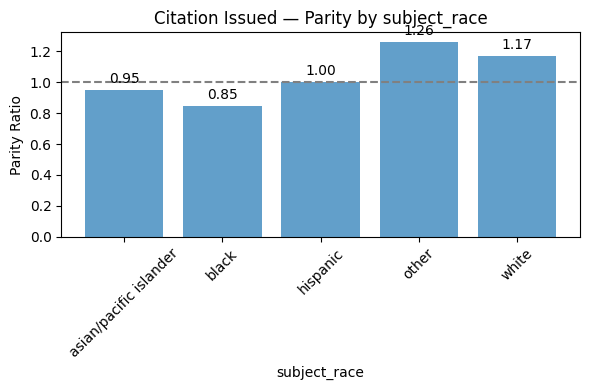


Citation Issued
 Overall is_citation: 0.417
 Group rates:
subject_sex
female    0.496603
male      0.379326

 Parity ratios:
subject_sex
female    1.192032
male      0.910524


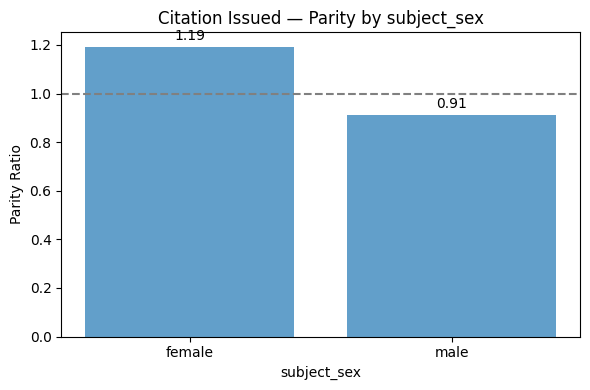


Reweighting factors for subject_race →
is_citation                    0         1
subject_race                              
asian/pacific islander  0.964900  1.053676
black                   0.902237  1.178883
hispanic                0.999106  1.001254
other                   1.227692  0.793828
white                   1.136358  0.856136

Reweighting factors for subject_sex →
is_citation         0         1
subject_sex                    
female       1.158922  0.838904
male         0.939943  1.098268


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) Inspect columns
print("Columns in df_cleaned:\n", df_cleaned.columns.tolist())

# 2) Define your binary outcome
#    Here we use citation_issued; fill NaNs as False, then cast to int (0/1).
df_cleaned['is_citation'] = df_cleaned['citation_issued'].fillna(False).astype(int)

# helper for parity + plotting
def parity_ratio_and_plot(df, outcome, group_col, title):
    overall = df[outcome].mean()
    grp_rate = df.groupby(group_col)[outcome].mean()
    parity   = grp_rate / overall

    print(f"\n{title}")
    print(f" Overall {outcome}: {overall:.3f}")
    print(" Group rates:\n", grp_rate.to_string(), sep="")
    print("\n Parity ratios:\n", parity.to_string(), sep="")

    # bar plot
    plt.figure(figsize=(6,4))
    bars = plt.bar(parity.index.astype(str), parity, alpha=0.7)
    plt.axhline(1, color='gray', linestyle='--')
    plt.title(f"{title} — Parity by {group_col}")
    plt.xlabel(group_col)
    plt.ylabel("Parity Ratio")
    plt.xticks(rotation=45 if group_col=='subject_race' else 0)
    for b in bars:
        h = b.get_height()
        plt.annotate(f"{h:.2f}",
                     (b.get_x()+b.get_width()/2, h),
                     ha='center', va='bottom',
                     xytext=(0,3), textcoords="offset points")
    plt.tight_layout()
    plt.show()

# 3) Compute & plot for race
parity_ratio_and_plot(
    df_cleaned,
    outcome='is_citation',
    group_col='subject_race',
    title='Citation Issued'
)

# 4) Compute & plot for gender/sex
parity_ratio_and_plot(
    df_cleaned,
    outcome='is_citation',
    group_col='subject_sex',
    title='Citation Issued'
)

# 5) Kamiran–Calders reweighting
def add_reweight(df, outcome, group_col, new_col_name):
    n   = len(df)
    p_y = df[outcome].value_counts(normalize=True)        # P(Y=y)
    p_g = df[group_col].value_counts(normalize=True)      # P(G=g)
    joint = df.groupby([group_col, outcome]).size() / n   # P(G=g, Y=y)

    weights = {}
    for g in p_g.index:
        for y in [0,1]:
            pj = joint.get((g,y), 0)
            weights[(g,y)] = (p_g[g] * p_y[y]) / pj if pj>0 else 1.0

    # attach to df, defaulting to 1.0 if key missing
    df[new_col_name] = df.apply(
        lambda r: weights.get((r[group_col], r[outcome]), 1.0),
        axis=1
    )

    # print weight table
    wt_s = pd.Series(weights)
    wt_s.index.set_names([group_col, outcome], inplace=True)
    wt_df = wt_s.unstack(outcome)
    print(f"\nReweighting factors for {group_col} →\n", wt_df.to_string(), sep="")

# 6) Add race‐based and sex‐based weight columns
add_reweight(df_cleaned, 'is_citation', 'subject_race', 'cite_wt_race')
add_reweight(df_cleaned, 'is_citation', 'subject_sex',  'cite_wt_sex')


<ipython-input-10-580b69ab2761>:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(race_parity.index, rotation=45, ha='right')


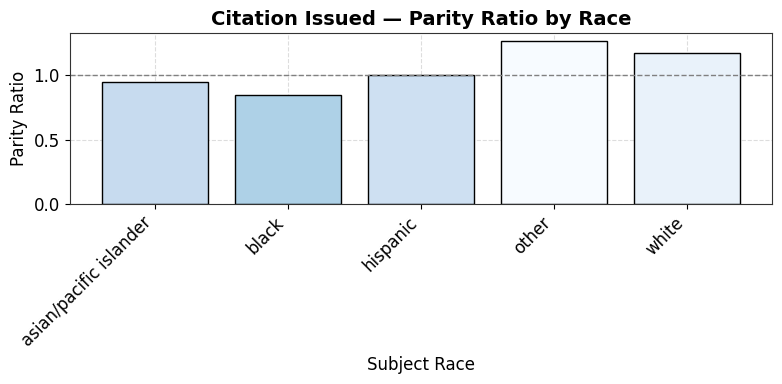

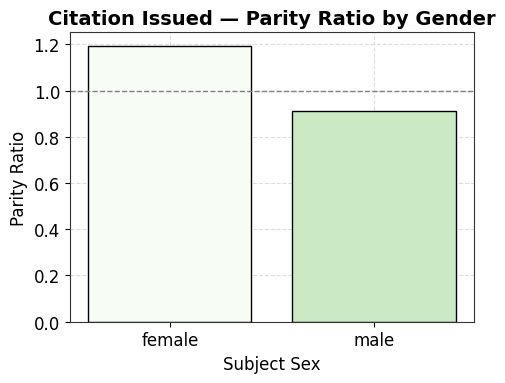

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Make sure your binary target exists:
df_cleaned['is_citation'] = df_cleaned['citation_issued'].fillna(False).astype(int)

# Compute parity ratios
overall = df_cleaned['is_citation'].mean()
race_parity = df_cleaned.groupby('subject_race')['is_citation'].mean() / overall
sex_parity  = df_cleaned.groupby('subject_sex') ['is_citation'].mean() / overall

# Common styling
plt.rcParams.update({
    'figure.facecolor': 'white',
    'axes.edgecolor': '#333333',
    'axes.grid': True,
    'grid.color': '#dddddd',
    'grid.linestyle': '--',
    'axes.axisbelow': True,
    'font.size': 12
})

# Race parity plot
fig, ax = plt.subplots(figsize=(8,4))
bars = ax.bar(race_parity.index, race_parity,
              color=plt.cm.Blues_r(race_parity / race_parity.max()),
              edgecolor='black')
ax.axhline(1, color='gray', linestyle='--', linewidth=1)
ax.set_title("Citation Issued — Parity Ratio by Race", fontsize=14, weight='bold')
ax.set_xlabel("Subject Race")
ax.set_ylabel("Parity Ratio")
ax.set_xticklabels(race_parity.index, rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Sex parity plot
fig, ax = plt.subplots(figsize=(5,4))
bars = ax.bar(sex_parity.index, sex_parity,
              color=plt.cm.Greens_r(sex_parity / sex_parity.max()),
              edgecolor='black')
ax.axhline(1, color='gray', linestyle='--', linewidth=1)
ax.set_title("Citation Issued — Parity Ratio by Gender", fontsize=14, weight='bold')
ax.set_xlabel("Subject Sex")
ax.set_ylabel("Parity Ratio")
plt.tight_layout()
plt.show()
